In [1]:
import os
import pandas as pd
from databricks import sql
from dotenv import load_dotenv

load_dotenv()

connection = sql.connect(
    server_hostname=os.getenv("DATABRICKS_HOST").replace("https://","").replace("http://",""),
    http_path="/sql/1.0/warehouses/fe659a9780b351a1",
    access_token=os.getenv("DATABRICKS_TOKEN"),
)

test_query = """
SELECT subject_id, study_id, findings, impression, label, confidence
FROM workspace.default.mimic_cxr_test_set_label_explanation_consensus_v1
WHERE findings IS NOT NULL
  AND impression IS NOT NULL
  AND label IN ('Normal', 'Abnormal')
"""

df_test = pd.read_sql(test_query, connection)
connection.close()


C:\Users\jaredpc\AppData\Local\Temp\ipykernel_102508\2458859878.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_test = pd.read_sql(test_query, connection)


C:\Users\jaredpc\Documents\Projects\Onprem-Radiology-Anomaly-Classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test samples: 4472
Using device: cuda


C:\Users\jaredpc\Documents\Projects\Onprem-Radiology-Anomaly-Classification\.venv\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Computing embeddings for t-SNE...
Embedding shape: (2000, 768)
Running t-SNE (this can take a bit)...
Plotting...


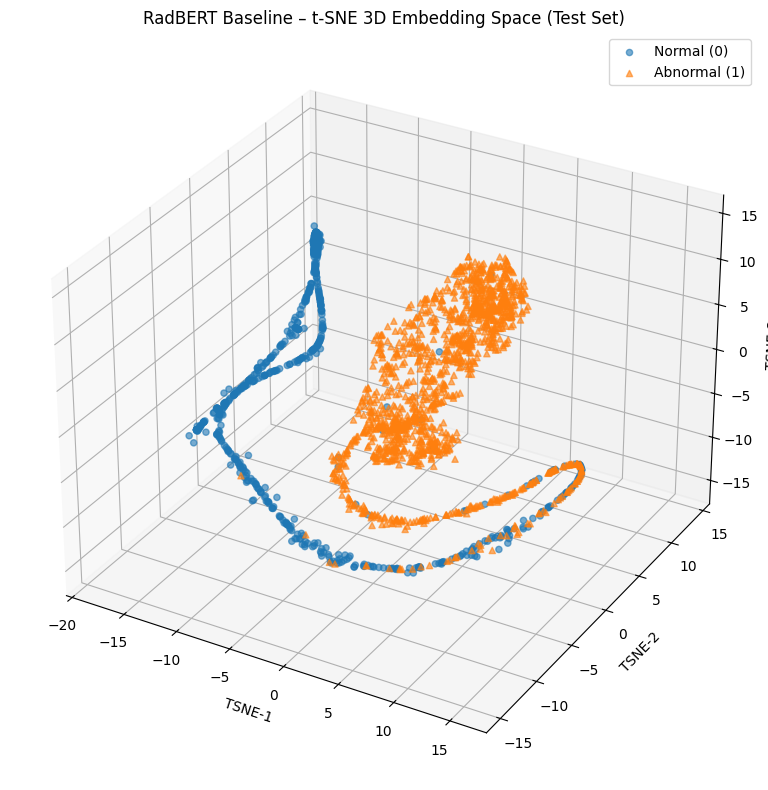

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ===========================
# 4. Prep test texts + labels
# ===========================
# Create a unified text field like in training
df_test["Context"] = (df_test["findings"].fillna("") + " " +
                      df_test["impression"].fillna("")).str.strip()

# Map labels to ints
label_map = {"Normal": 0, "Abnormal": 1}
df_test["Result"] = df_test["label"].map(label_map)

test_texts = df_test["Context"].tolist()
test_labels = df_test["Result"].tolist()

print("Test samples:", len(test_texts))

# ===========================
# 5. Load model & tokenizer
# ===========================
MODEL_DIR = "./trained_models/zzxslp_RadBERT-RoBERTa-4m_baseline"
HF_MODEL_NAME = "zzxslp/RadBERT-RoBERTa-4m"  # for tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    local_files_only=True
).to(device)


# ===========================
# 6. Get sentence embeddings
# ===========================
def get_sentence_embeddings(texts, labels,
                            model, tokenizer, device,
                            max_samples=2000,
                            batch_size=32,
                            max_length=120):
    model.eval()

    texts = texts[:max_samples]
    labels = labels[:max_samples]

    all_embs = []
    all_labs = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            enc = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            ).to(device)

            # Ask model for hidden states
            outputs = model(**enc, output_hidden_states=True)
            last_hidden = outputs.hidden_states[-1]  # [B, L, H]

            # Masked mean pooling over tokens
            mask = enc["attention_mask"].unsqueeze(-1)  # [B, L, 1]
            masked_hidden = last_hidden * mask
            lengths = mask.sum(dim=1).clamp(min=1)      # [B, 1]
            sent_emb = masked_hidden.sum(dim=1) / lengths  # [B, H]

            all_embs.append(sent_emb.cpu())
            all_labs.extend(batch_labels)

    emb_tensor = torch.cat(all_embs, dim=0)  # [N, H]
    emb_array = emb_tensor.numpy()
    label_array = np.array(all_labs)
    return emb_array, label_array


print("Computing embeddings for t-SNE...")
emb_array, label_array = get_sentence_embeddings(
    test_texts,
    test_labels,
    model,
    tokenizer,
    device,
    max_samples=2000,   # tweak up/down if you want
    batch_size=32,
    max_length=120,
)
print("Embedding shape:", emb_array.shape)

# ===========================
# 7. t-SNE to 3D
# ===========================
print("Running t-SNE (this can take a bit)...")
tsne = TSNE(
    n_components=3,
    learning_rate="auto",
    init="random",
    perplexity=30,
    random_state=42,
)
emb_3d = tsne.fit_transform(emb_array)  # [N, 3]

# ===========================
# 8. 3D scatter plot
# ===========================
print("Plotting...")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

labels_np = label_array
normal_idx = labels_np == 0
abnormal_idx = labels_np == 1

ax.scatter(
    emb_3d[normal_idx, 0],
    emb_3d[normal_idx, 1],
    emb_3d[normal_idx, 2],
    alpha=0.6,
    label="Normal (0)",
)
ax.scatter(
    emb_3d[abnormal_idx, 0],
    emb_3d[abnormal_idx, 1],
    emb_3d[abnormal_idx, 2],
    alpha=0.6,
    label="Abnormal (1)",
    marker="^",
)

ax.set_title("RadBERT Baseline – t-SNE 3D Embedding Space (Test Set)")
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")
ax.set_zlabel("TSNE-3")
ax.legend()
plt.tight_layout()
plt.show()
